In [127]:
import numpy as np
import pandas as pd
import xgboost as xgb
import pickle
from sklearn import datasets
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [128]:
names = [
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'income',
]


In [130]:
data = pd.read_csv('adult.data', names=names)
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Data Preprocessing

In [131]:
# data.isna().sum()

there is no missing value in the dataset. however when checking the unique entries in the column,
i noticed the symbol "?" was found in some of the features and this needs to be handled just like null values.

In [132]:
data['workclass'].value_counts()

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64

In [133]:
my_columns = list(data.columns)
for col in my_columns:
    data.loc[data[col]==" ?", col] = np.nan

In [134]:
data.isna().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

In [135]:
# we will check the size of the missing data to determine if we will drop the rows oe use some better measures 


workclass_na = data.isna().sum()[1]
workclass_sum = data['workclass'].value_counts().sum()

occupation_na = data.isna().sum()[6]
occupation_sum = data['occupation'].value_counts().sum()

native_na = data.isna().sum()[13]
native_sum = data['native-country'].value_counts().sum()


# lets check the percentae of the data that is null, if its large we can use the most occuring data.

# However if its small we can drop those entries
print('the percentage of null values in workclass column is {} %'.format((workclass_na/(workclass_na + workclass_sum)) * 100 ))
print('the percentage of null values in occupation column is {} %'.format((occupation_na/(occupation_na + occupation_sum)) * 100 ))
print('the percentage of null values in Native_country column is {} %'.format((native_na/(native_na + native_sum)) * 100 ))

the percentage of null values in workclass column is 5.638647461687294 %
the percentage of null values in occupation column is 5.660145572924664 %
the percentage of null values in Native_country column is 1.7904855501980899 %


#### Since the percentage are not much, we can go ahead and drop the rows

In [136]:
# checking the total entries in the data frame before dropping
print('Before dropping the rows with null values the entries id {}'.format(data.shape))

data = data.dropna(axis=0, how='any')

print('Afer dropping the total entries is {}'.format(data.shape))

Before dropping the rows with null values the entries id (32561, 15)
Afer dropping the total entries is (30162, 15)


In [137]:
# we will be dropping some columns that will not be relevant in training the model here 
data.drop(['fnlwgt','education'], axis=1, inplace=True)

In [138]:
data.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


#### Merging data with close characteristics


#### 1. Occupation

In [14]:
data['occupation'].value_counts()

 Prof-specialty       4038
 Craft-repair         4030
 Exec-managerial      3992
 Adm-clerical         3721
 Sales                3584
 Other-service        3212
 Machine-op-inspct    1966
 Transport-moving     1572
 Handlers-cleaners    1350
 Farming-fishing       989
 Tech-support          912
 Protective-serv       644
 Priv-house-serv       143
 Armed-Forces            9
Name: occupation, dtype: int64

##### the following Occupations will be merged

 Prof-specialty and Exec-managerial == Prof-specialty

Machine-op-inspct and Farming-fishing == IT

Tech-support and Protective-serv == technical

Craft-repair, Sales and Transport-moving= Transport-moving

Other-service and Handlers-cleaners = Other-service

Armed-Forces and  Priv-house-serv = Priv-house-serv

**Note that this merger were done based on the prportion of these occupations that earn below and above 50K**

**Hence occupations with relatively close prportions were meerged together** 


In [140]:
data['occupation']=np.where(data['occupation'] ==' Prof-specialty', ' Exec-managerial', data['occupation'])

data['occupation']=np.where(data['occupation'] ==' Machine-op-inspct', ' Farming-fishing', data['occupation'])

data['occupation']=np.where(data['occupation'] ==' Adm-clerical', ' Farming-fishing', data['occupation'])

data['occupation']=np.where(data['occupation'] ==' Tech-support', ' Protective-serv', data['occupation'])

data['occupation']=np.where(data['occupation'] ==' Craft-repair', ' Transport-moving', data['occupation'])

data['occupation']=np.where(data['occupation'] ==' Handlers-cleaners', ' Other-service', data['occupation'])

data['occupation']=np.where(data['occupation'] ==' Armed-Forces', ' Priv-house-serv', data['occupation'])

data['occupation']=np.where(data['occupation'] ==' Sales', ' Transport-moving', data['occupation'])

data['occupation'].unique()

array([' Farming-fishing', ' Exec-managerial', ' Other-service',
       ' Transport-moving', ' Protective-serv', ' Priv-house-serv'],
      dtype=object)

#### 2. Marital Status

##### the following Occupations will be merged

Married-AF-spouse and Married-civ-spouse == Married-civ-spouse

Never-married and Separated == IT

Divorced, Widowed  and Married-spouse-absent == technical


**Note that this merger were done based on the prportion of the marital-status that earn below and above 50K**

**Hence occupations with relatively close prportions were meerged together** 


In [141]:
data['marital-status']=np.where(data['marital-status'] ==' Married-AF-spouse', ' Married-civ-spouse', data['marital-status'])

data['marital-status']=np.where(data['marital-status'] ==' Never-married', ' Separated', data['marital-status'])

data['marital-status']=np.where(data['marital-status'] ==' Divorced', ' Married-spouse-absent', data['marital-status'])

data['marital-status']=np.where(data['marital-status'] ==' Widowed', ' Married-spouse-absent', data['marital-status'])

data['marital-status'].unique()

array([' Separated', ' Married-civ-spouse', ' Married-spouse-absent'],
      dtype=object)

### 3. Relationship

In [17]:
data['relationship']=np.where(data['relationship'] ==' Wife', ' Husband', data['relationship'])

data['relationship']=np.where(data['relationship'] ==' Not-in-family', ' Unmarried', data['relationship'])

data['relationship']=np.where(data['relationship'] ==' Own-child', ' Other-relative', data['relationship'])

In [139]:
data['relationship'].unique()

array([' Not-in-family', ' Husband', ' Wife', ' Own-child', ' Unmarried',
       ' Other-relative'], dtype=object)

### 4. native country

**here to reduce the number of columns created by one hot encoding, we will group the countries by the continents they fall into**

**create a function to tp group the countries by continents except for united states, canada and others** 

In [142]:
# instantiating a function to pass the columns throug and reolace the data by their continent name
try:
    def update_data(original_string, category):
        characters_to_update = category
        new_string = original_string
        for character in characters_to_update:
          new_string = new_string.replace(character, category[0])
        return new_string
except Exception as e:
    print(e)

    

# create a function that maps a list of strings/series to the function created above and returns
# the continent in place of the country 
try:
    def strip_series(series):
           new_series= list(map(remove_char, series))
           new_series = pd.Series(new_series)
           return new_series
except Exception as e:
    print (e)
else:
    print('Program Executed')
        

Program Executed


In [143]:
# we group by continents and apply the function creayted above

Americans = ['Americans',' Cuba',' Jamaica',' Mexico',' Ecuador',' Jamaica',' Puerto-Rico',' Honduras',' Peru',' El-Salvador',
             ' Columbia',' Trinadad&Tobago',' Nicaragua',' El-Salvador',' Guatemala',' Dominican-Republic']

Europeans = ['Europeans',' England',' Greece',' Italy',' France',' Scotland',' Holand-Netherlands',' Hungary',' Portugal',
       ' Germany',' Poland',' Ireland',' Yugoslavia']


Asians =['Asians',' Iran',' India',' Taiwan',' Haiti',' China',' Laos',' Japan',' Vietnam',' Cambodia',' Philippines',' Thailand',' Hong']


x = update_data(data['native-country'], Americans)
y= update_data(x, Europeans)
z = update_data(y, Asians)

# we assign the updated data to the column
data['native-country']= z

In [144]:
data['native-country'].unique()

array([' United-States', 'Americans', 'Asians', 'Europeans', ' Canada',
       ' South', ' Outlying-US(Guam-USVI-etc)'], dtype=object)

### 5. Sex and Income

In [145]:
#here we use the label encoding function by setting "drop_first=True" in the get dummies pandas function

data['income'] = pd.get_dummies(data.income, drop_first=True)
data['sex']= pd.get_dummies(data.sex, drop_first=True)

In [146]:
# we will use one hot encoding/ pd.get dummies to convert the other ategorical variables into numerical variables

workclass_ = pd.get_dummies(data.workclass)
marital_status = pd.get_dummies(data['marital-status'])
occupation_ = pd.get_dummies(data['occupation'])
relationship_ = pd.get_dummies(data['relationship'])
race_ = pd.get_dummies(data['race'])
native_country = pd.get_dummies(data['native-country'])


In [147]:
# joining the dataframes to the original dataframe

df1 = pd.concat([workclass_, marital_status], axis=1)
df2 = pd.concat([df1, occupation_], axis=1)
df3 = pd.concat([df2, relationship_], axis=1)
df4 = pd.concat([df3, race_], axis=1)
df5 = pd.concat([df4, native_country], axis=1)
dataset = df5 = pd.concat([data, df5], axis=1)


In [148]:
dataset.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,...,Black,Other,White,Canada,Outlying-US(Guam-USVI-etc),South,United-States,Americans,Asians,Europeans
0,39.0,State-gov,13.0,Separated,Farming-fishing,Not-in-family,White,1,2174.0,0.0,...,0,0,1,0,0,0,1,0,0,0
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,1,0.0,0.0,...,0,0,1,0,0,0,1,0,0,0
2,38.0,Private,9.0,Married-spouse-absent,Other-service,Not-in-family,White,1,0.0,0.0,...,0,0,1,0,0,0,1,0,0,0
3,53.0,Private,7.0,Married-civ-spouse,Other-service,Husband,Black,1,0.0,0.0,...,1,0,0,0,0,0,1,0,0,0
4,28.0,Private,13.0,Married-civ-spouse,Exec-managerial,Wife,Black,0,0.0,0.0,...,1,0,0,0,0,0,0,1,0,0


In [149]:
# we noticed that the column names has a white space in front so, lets remove the white space before the column names
def remove_space(data):
    my_columns=[]
    for cols in data:
        my_columns.append(cols.strip(" "))
    return my_columns

new_columns = remove_space(dataset.columns)
new_columns = new_columns

In [150]:
# lets the drop the features alredy converted through pd.get dummies
dataset.drop(['workclass','marital-status','occupation','relationship','native-country','race'], axis=1, inplace=True)

In [151]:
# we confirm if the data is in the right format to train with the XG booost model
print(dataset.dtypes)
dataset.head()

age                            float64
education-num                  float64
sex                              uint8
capital-gain                   float64
capital-loss                   float64
hours-per-week                 float64
income                           uint8
 Federal-gov                     uint8
 Local-gov                       uint8
 Private                         uint8
 Self-emp-inc                    uint8
 Self-emp-not-inc                uint8
 State-gov                       uint8
 Without-pay                     uint8
 Married-civ-spouse              uint8
 Married-spouse-absent           uint8
 Separated                       uint8
 Exec-managerial                 uint8
 Farming-fishing                 uint8
 Other-service                   uint8
 Priv-house-serv                 uint8
 Protective-serv                 uint8
 Transport-moving                uint8
 Husband                         uint8
 Not-in-family                   uint8
 Other-relative          

,age,education-num,sex,capital-gain,capital-loss,hours-per-week,income,Federal-gov,Local-gov,Private,...,Black,Other,White,Canada,Outlying-US(Guam-USVI-etc),South,United-States,Americans,Asians,Europeans
0,39.0,13.0,1,2174.0,0.0,40.0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,50.0,13.0,1,0.0,0.0,13.0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
2,38.0,9.0,1,0.0,0.0,40.0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
3,53.0,7.0,1,0.0,0.0,40.0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
4,28.0,13.0,0,0.0,0.0,40.0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0


#### Our Dataset is ready for Modeling

### Data Modeling

In [152]:
X= dataset.drop('income', axis=1)
y= dataset['income']

In [ ]:
# # as the datapoints differ a lot in magnitude, we'll scale them
# from sklearn.preprocessing import StandardScaler
# scaler=StandardScaler()
# scaled_data=scaler.fit_transform(X)

In [159]:
# Note thatalthoug the magnitude of the data differs, standardization did not improve accuracy when tested,

from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y=train_test_split(X,y,test_size=0.3,random_state=42)

In [160]:
# fit model no training data
model = XGBClassifier(objective='binary:logistic')
model.fit(train_x, train_y)

[19:27:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [161]:
# cheking  accuracy
y_pred = model.predict(test_x)
accuracy = accuracy_score(test_y,y_pred)
accuracy

0.869598850701735

In [98]:
# Now to increae the accuracy of the model, we'll do hyperparameter tuning using grid search
from sklearn.model_selection import GridSearchCV

param_grid={
   
    ' learning_rate':[1,0.5,0.1,0.01,0.001],
    'max_depth': [3,5,10,20],
    'n_estimators':[10,50,100,200]
    
    
}

In [99]:
grid= GridSearchCV(XGBClassifier(objective='binary:logistic'),param_grid, verbose=3, n_jobs=-1)

In [100]:
grid.fit(train_x, train_y)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 15.3min finished
C:\Users\USER\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:32:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: {  learning_rate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:32:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameter

In [101]:
grid.best_params_

{' learning_rate': 1, 'max_depth': 3, 'n_estimators': 200}

In [102]:
# Create new model using the same parameters
new_model=XGBClassifier(learning_rate= 1, max_depth= 3, n_estimators= 200)
new_model.fit(train_x, train_y)

[18:35:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [103]:
# cheking  accuracy
y_pred = new_model.predict(test_x)
accuracy = accuracy_score(test_y,y_pred)
accuracy

0.8689357940103879

In [162]:
#Our unprunned model shows a higher accuracy on the test score so we will save the model.

filename = 'xgboost_model.pickle'
pickle.dump(model, open(filename, 'wb'))

loaded_model = pickle.load(open(filename, 'rb'))

Text(0.5, 15.0, 'Predicted label')

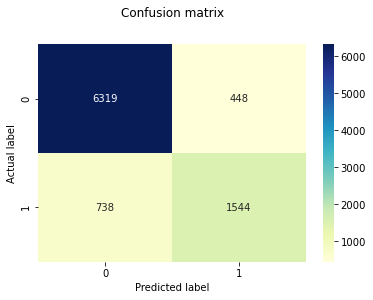

In [110]:
# Creating a Heatmap for the confusion matrix. 
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(test_y,y_pred)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [117]:
from sklearn.metrics import confusion_matrix as cm

cm =cm(test_y,y_pred)
true_positive = cm[0][0]
false_positive = cm[0][1]
false_negative = cm[1][0]
true_negative = cm[1][1]

In [118]:
# Breaking down the formula for Accuracy
Accuracy = (true_positive + true_negative) / (true_positive +false_positive + false_negative + true_negative)
Accuracy

0.8703724168416399

In [119]:
# Precison
Precision = true_positive/(true_positive+false_positive)
Precision

0.9382296438599084

In [120]:
# Recall
Recall = true_positive/(true_positive+false_negative)
Recall

0.8937218468468469

In [121]:
# F1 Score
F1_Score = 2*(Recall * Precision) / (Recall + Precision)
F1_Score

0.9154350803835339

In [125]:
from sklearn.metrics import  roc_curve, roc_auc_score

# Area Under Curve
auc = roc_auc_score(test_y,y_pred)
auc

0.8036897561981401

### Conclusion

We can say that the Model did a Nice job in predicting the survival of persond on board yhe titanic ship